In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

Train and evaluate a linear regression:  
- input: iBOT-vMF backbone embeddings
- output: probabilities for each class (9 total in COCPIT dataset), or image features

In [2]:
data_dir = '/home/jko/ssl-cpi-analysis/data'
merged_file = os.path.join(data_dir, 'embeddings_env_class_merged.parquet')
if os.path.exists(merged_file):
    print(f'loading merged file: {merged_file}...')
    df_merged = pd.read_parquet(merged_file)
else:
    print(f'creating merged file: {merged_file}...')
    # import combined env/classification/img features dataframe
    env_data_path = '../data/combined_campaign_env_data.csv'
    df = pd.read_csv(env_data_path)
    env_vars = ['Classification', 'Latitude [degrees]','Longitude [degrees]', 'Altitude [m]',
    'Pressure [hPa]','Temperature [C]', 'Ice Water Content [g/m3]', 
    'PSD IWC [g/m3]']
    # import embeddings 
    emb_path = '../data/combined_campaign_features.pth'
    emb = torch.load(emb_path)
    df_emb = pd.DataFrame(emb.numpy())
    # merge the two datasets 
    df_merged = df.merge(df_emb, left_index=True, right_index=True)
    # replace -999 with NaN
    df_merged = df_merged[~(df == -999.99).any(axis=1)]
    df_merged = df_merged.dropna(subset=['filename'])
    # remove outliers (outside of 1/99 percentiles)
    def remove_outliers(df, columns):
        df_clean = df.copy()
        for col in columns:
            lower = df_clean[col].quantile(0.01)
            upper = df_clean[col].quantile(0.99)
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        return df_clean
    df_merged = remove_outliers(df_merged, env_vars) 
    print(f'saving file as parquet file..')
    df_merged.to_parquet(merged_file, index=False) # save as parquet

creating merged file: /home/jko/ssl-cpi-analysis/data/embeddings_env_class_merged.parquet...


TypeError: unsupported operand type(s) for -: 'str' and 'str'

Fit Linear Classifier

In [13]:
# Train/Val/Test split 
random_seed=666
# 70% train, 30% temp
df_train, df_temp = train_test_split(df_merged, test_size=0.3, random_state=random_seed)

# Split temp into 15% val, 15% test (each is 0.15 of original)
df_val, df_test = train_test_split(df_merged, test_size=0.5, random_state=random_seed)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

# Prepare data
x_cols = [str(i) for i in range(0, 384)]
x_train = df_train[x_cols]
x_val = df_val[x_cols]

# Use "Classification" as the target
y_train = df_train["Classification"]
y_val = df_val["Classification"]

# Fit logistic regression
clf = LogisticRegression(max_iter=1000, random_state=random_seed)
clf.fit(x_train, y_train)

# Predict on validation set
y_val_pred = clf.predict(x_val)

# Evaluate
acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {acc:.3f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Train: 404803, Val: 289145, Test: 289146


/home/jko/miniconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.854

Classification Report:
                     precision    recall  f1-score   support

               agg       0.74      0.75      0.74     57663
           budding       0.71      0.64      0.67      8139
            bullet       0.87      0.89      0.88      6784
            column       0.83      0.70      0.76      6617
     compact_irreg       0.92      0.94      0.93    162449
planar_polycrystal       0.74      0.67      0.70     18128
             rimed       0.82      0.78      0.80     29365

          accuracy                           0.85    289145
         macro avg       0.80      0.77      0.78    289145
      weighted avg       0.85      0.85      0.85    289145



In [16]:
# save model
model_dir = '/home/jko/ssl-cpi-analysis/models'
model_savepath = os.path.join(model_dir, 'logistic_regression.pkl')
with open(model_savepath, 'wb') as f:
    pickle.dump(clf, f)

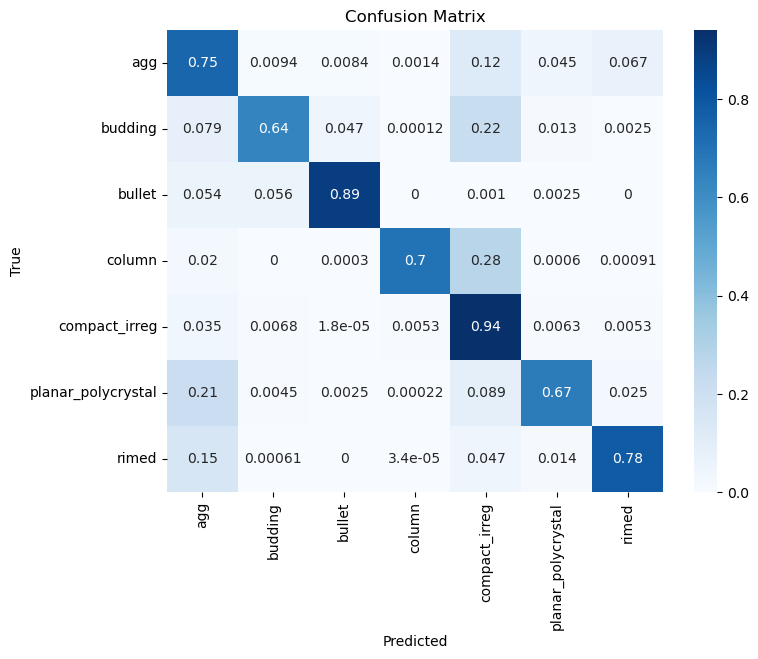

In [18]:
# Confusion matrix plot
cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
df_merged.shape

(578291, 432)

# Scratch

In [2]:
# import combined env/classification/img features dataframe
env_data_path = '../data/combined_campaign_env_data.csv'
df = pd.read_csv(env_data_path)
env_vars = ['Latitude [degrees]','Longitude [degrees]', 'Altitude [m]',
'Pressure [hPa]','Temperature [C]', 'Ice Water Content [g/m3]', 
'PSD IWC [g/m3]']
# replace -999 with NaN
df_clean = df[~(df == -999.99).any(axis=1)]
df_clean = df_clean.dropna(subset=['filename'])
# remove outliers (outside of 1/99 percentiles)
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        lower = df_clean[col].quantile(0.01)
        upper = df_clean[col].quantile(0.99)
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean
df_no_outliers = remove_outliers(df_clean, env_vars)

In [3]:
df.shape

(759632, 48)

In [8]:
df[df['filename'].isna()]

,index,filename,date,Frame Width [pixels],Frame Height [pixels],Particle Width [micrometers],Particle Height [micrometers],Cutoff [%],Aggregate [%],Budding [%],...,Altitude [m],Pressure [hPa],Temperature [C],Ice Water Content [g/m3],PSD IWC [g/m3],concentration ratio,area ratio,mass ratio,Campaign,Perimeter [pixels]


embeddings are of shape: (759632, 384)

In [5]:
len(df['filename'].unique())

759626

In [32]:
df_no_outliers.columns

Index(['index', 'filename', 'date', 'Frame Width [pixels]',
       'Frame Height [pixels]', 'Particle Width [micrometers]',
       'Particle Height [micrometers]', 'Cutoff [%]', 'Aggregate [%]',
       'Budding [%]', 'Bullet Rosette [%]', 'Column [%]',
       'Compact Irregular [%]', 'Fragment [%]', 'Planar Polycrystal [%]',
       'Rimed [%]', 'Sphere [%]', 'Classification', 'Blur', 'Contours [#]',
       'Edges', 'Std', 'Contour Area [pixels]', 'Contrast', 'Circularity',
       'Solidity', 'Complexity', 'Equivalent Diameter', 'Convex Perimeter',
       'Hull Area', 'Perimeter', 'Aspect Ratio', 'Extreme Points',
       'Area Ratio', 'Roundness', 'Perimeter-Area Ratio', 'Latitude [degrees]',
       'Longitude [degrees]', 'Altitude [m]', 'Pressure [hPa]',
       'Temperature [C]', 'Ice Water Content [g/m3]', 'PSD IWC [g/m3]',
       'concentration ratio', 'area ratio', 'mass ratio', 'Campaign',
       'Perimeter [pixels]'],
      dtype='object')

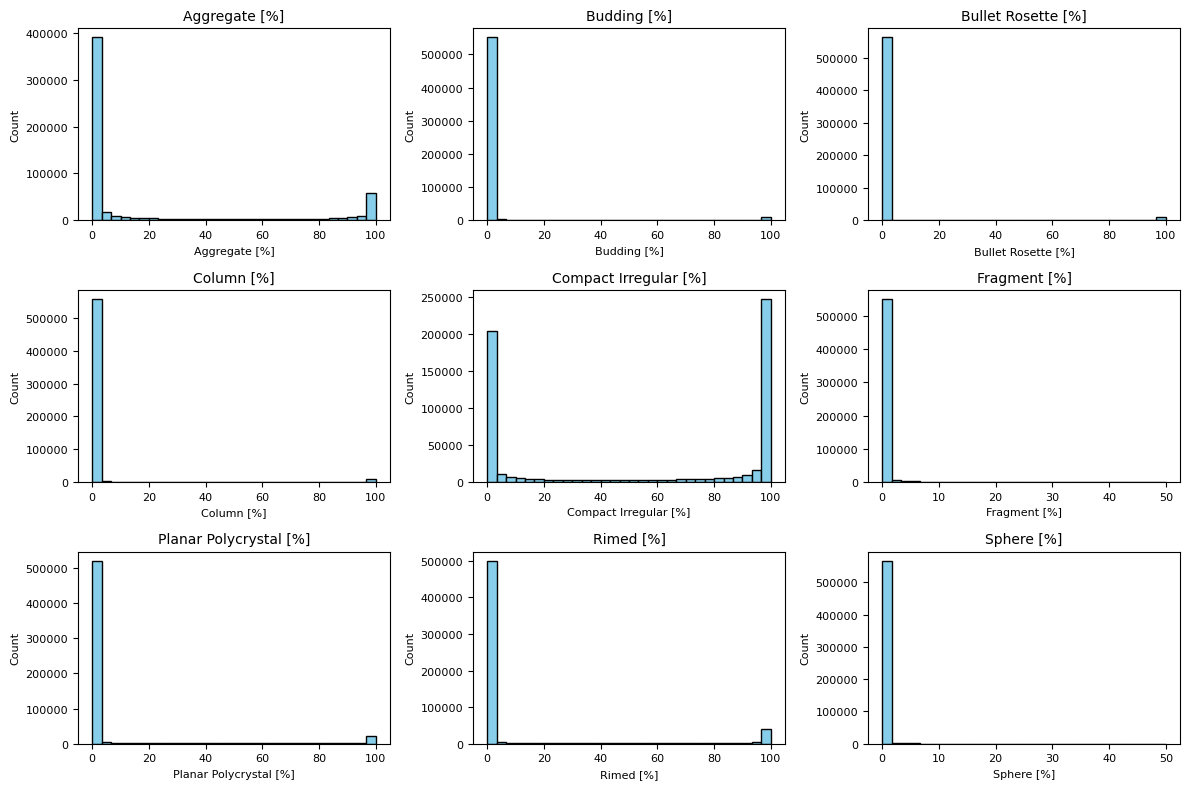

In [34]:
# plot distribution of last layer output (cls probs)
cls_cols = ['Aggregate [%]', 'Budding [%]', 'Bullet Rosette [%]', 'Column [%]', 'Compact Irregular [%]', 'Fragment [%]', 'Planar Polycrystal [%]', 'Rimed [%]', 'Sphere [%]']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(cls_cols):
    axes[i].hist(df_no_outliers[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='both', labelsize=8)

# Hide any unused subplots (if any)
for j in range(len(cls_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [35]:
# Print the number of samples of each classification
print(df_no_outliers['Classification'].value_counts())

Classification
compact_irreg         325006
agg                   115321
rimed                  58712
planar_polycrystal     36313
budding                16204
bullet                 13495
column                 13240
Name: count, dtype: int64


In [36]:
from sklearn.utils import resample

df_balanced = []
min_count = df_no_outliers['Classification'].value_counts().min()

for label in df_no_outliers['Classification'].unique():
    df_class = df_no_outliers[df_no_outliers['Classification'] == label]
    df_class_balanced = resample(df_class, replace=False, n_samples=min_count, random_state=42)
    df_balanced.append(df_class_balanced)

df_balanced = pd.concat(df_balanced)

In [41]:
# Print the number of samples of each classification after balancing data
print(df_balanced['Classification'].value_counts())

Classification
budding               13240
planar_polycrystal    13240
bullet                13240
compact_irreg         13240
agg                   13240
column                13240
rimed                 13240
Name: count, dtype: int64


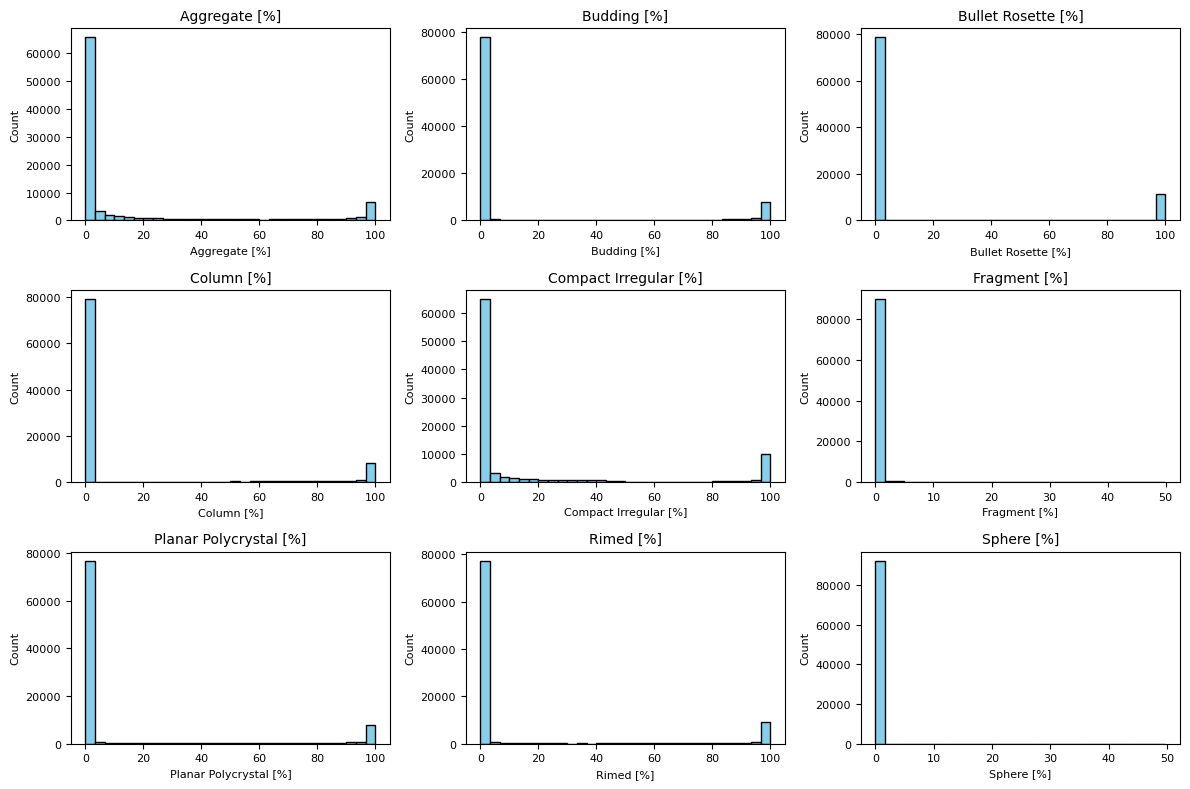

In [37]:
# plot distribution class probabilities with balanced df
cls_cols = ['Aggregate [%]', 'Budding [%]', 'Bullet Rosette [%]', 'Column [%]', 'Compact Irregular [%]', 'Fragment [%]', 'Planar Polycrystal [%]', 'Rimed [%]', 'Sphere [%]']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(cls_cols):
    axes[i].hist(df_balanced[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='both', labelsize=8)

# Hide any unused subplots (if any)
for j in range(len(cls_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [43]:
df_balanced[df_balanced['Classification']=='rimed'][cls_cols]

,Aggregate [%],Budding [%],Bullet Rosette [%],Column [%],Compact Irregular [%],Fragment [%],Planar Polycrystal [%],Rimed [%],Sphere [%]
625244,6.642,1.652,0.001,0.011,5.233,0.029,0.278,86.148,0.006
164182,10.940,0.000,0.000,0.000,0.336,0.000,0.000,88.724,0.000
565007,39.680,0.000,0.000,0.000,0.003,0.000,0.000,60.316,0.000
98541,0.003,0.000,0.000,0.001,0.000,34.773,0.000,65.223,0.000
135934,5.247,0.000,0.000,0.000,0.000,0.000,0.125,94.628,0.000
...,...,...,...,...,...,...,...,...,...
525369,3.907,0.086,0.000,0.006,3.216,0.063,0.038,92.682,0.002
588269,4.608,0.002,0.000,0.000,0.001,0.003,0.001,95.385,0.000
626265,1.349,0.046,0.000,0.001,0.148,0.002,0.012,98.441,0.001
390901,0.195,0.000,0.000,0.000,0.000,0.000,0.000,99.805,0.000


In [40]:
df_balanced['Classification'].unique()

array(['budding', 'planar_polycrystal', 'bullet', 'compact_irreg', 'agg',
       'column', 'rimed'], dtype=object)

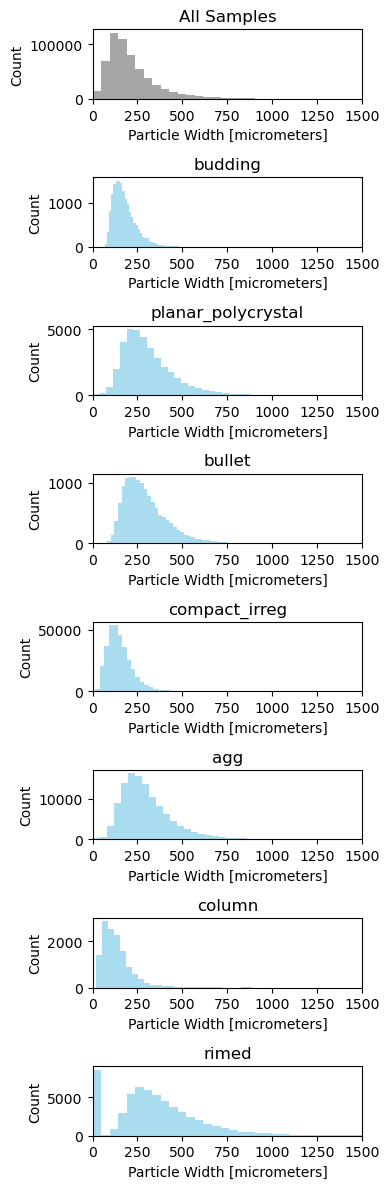

In [53]:
labels = ['budding', 'planar_polycrystal', 'bullet', 'compact_irreg', 'agg', 'column', 'rimed']
feature = "Particle Width [micrometers]"

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(4, 12))  # 8 rows, 1 column, wider and shorter
axes = axes.flatten()

xlim = (0, 1500)

# Plot total distribution in the first subplot
axes[0].hist(df_no_outliers[feature].dropna(), bins=50, color='gray', alpha=0.7)
axes[0].set_title('All Samples')
axes[0].set_xlabel(feature)
axes[0].set_ylabel('Count')
axes[0].set_xlim(xlim)

# Plot distributions by classification label in the remaining subplots
for i, label in enumerate(labels):
    axes[i+1].hist(
        df_no_outliers[df_no_outliers['Classification'] == label][feature].dropna(),
        bins=50, alpha=0.7, color='skyblue', edgecolor='none'
    )
    axes[i+1].set_title(label)
    axes[i+1].set_xlabel(feature)
    axes[i+1].set_ylabel('Count')
    axes[i+1].set_xlim(xlim)

plt.tight_layout()
plt.show()

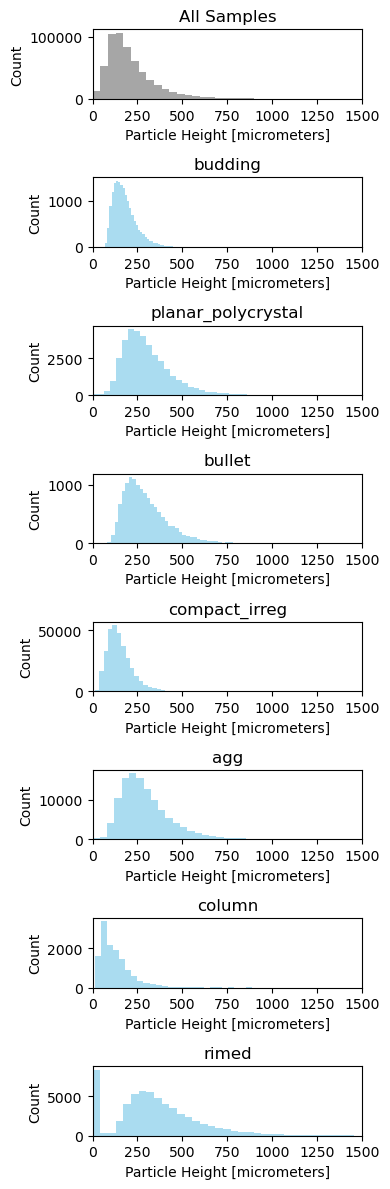

In [55]:
labels = ['budding', 'planar_polycrystal', 'bullet', 'compact_irreg', 'agg', 'column', 'rimed']
feature = "Particle Height [micrometers]"

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(4, 12))  # 8 rows, 1 column, wider and shorter
axes = axes.flatten()

xlim = (0, 1500)

# Plot total distribution in the first subplot
axes[0].hist(df_no_outliers[feature].dropna(), bins=50, color='gray', alpha=0.7)
axes[0].set_title('All Samples')
axes[0].set_xlabel(feature)
axes[0].set_ylabel('Count')
axes[0].set_xlim(xlim)

# Plot distributions by classification label in the remaining subplots
for i, label in enumerate(labels):
    axes[i+1].hist(
        df_no_outliers[df_no_outliers['Classification'] == label][feature].dropna(),
        bins=50, alpha=0.7, color='skyblue', edgecolor='none'
    )
    axes[i+1].set_title(label)
    axes[i+1].set_xlabel(feature)
    axes[i+1].set_ylabel('Count')
    axes[i+1].set_xlim(xlim)

plt.tight_layout()
plt.show()

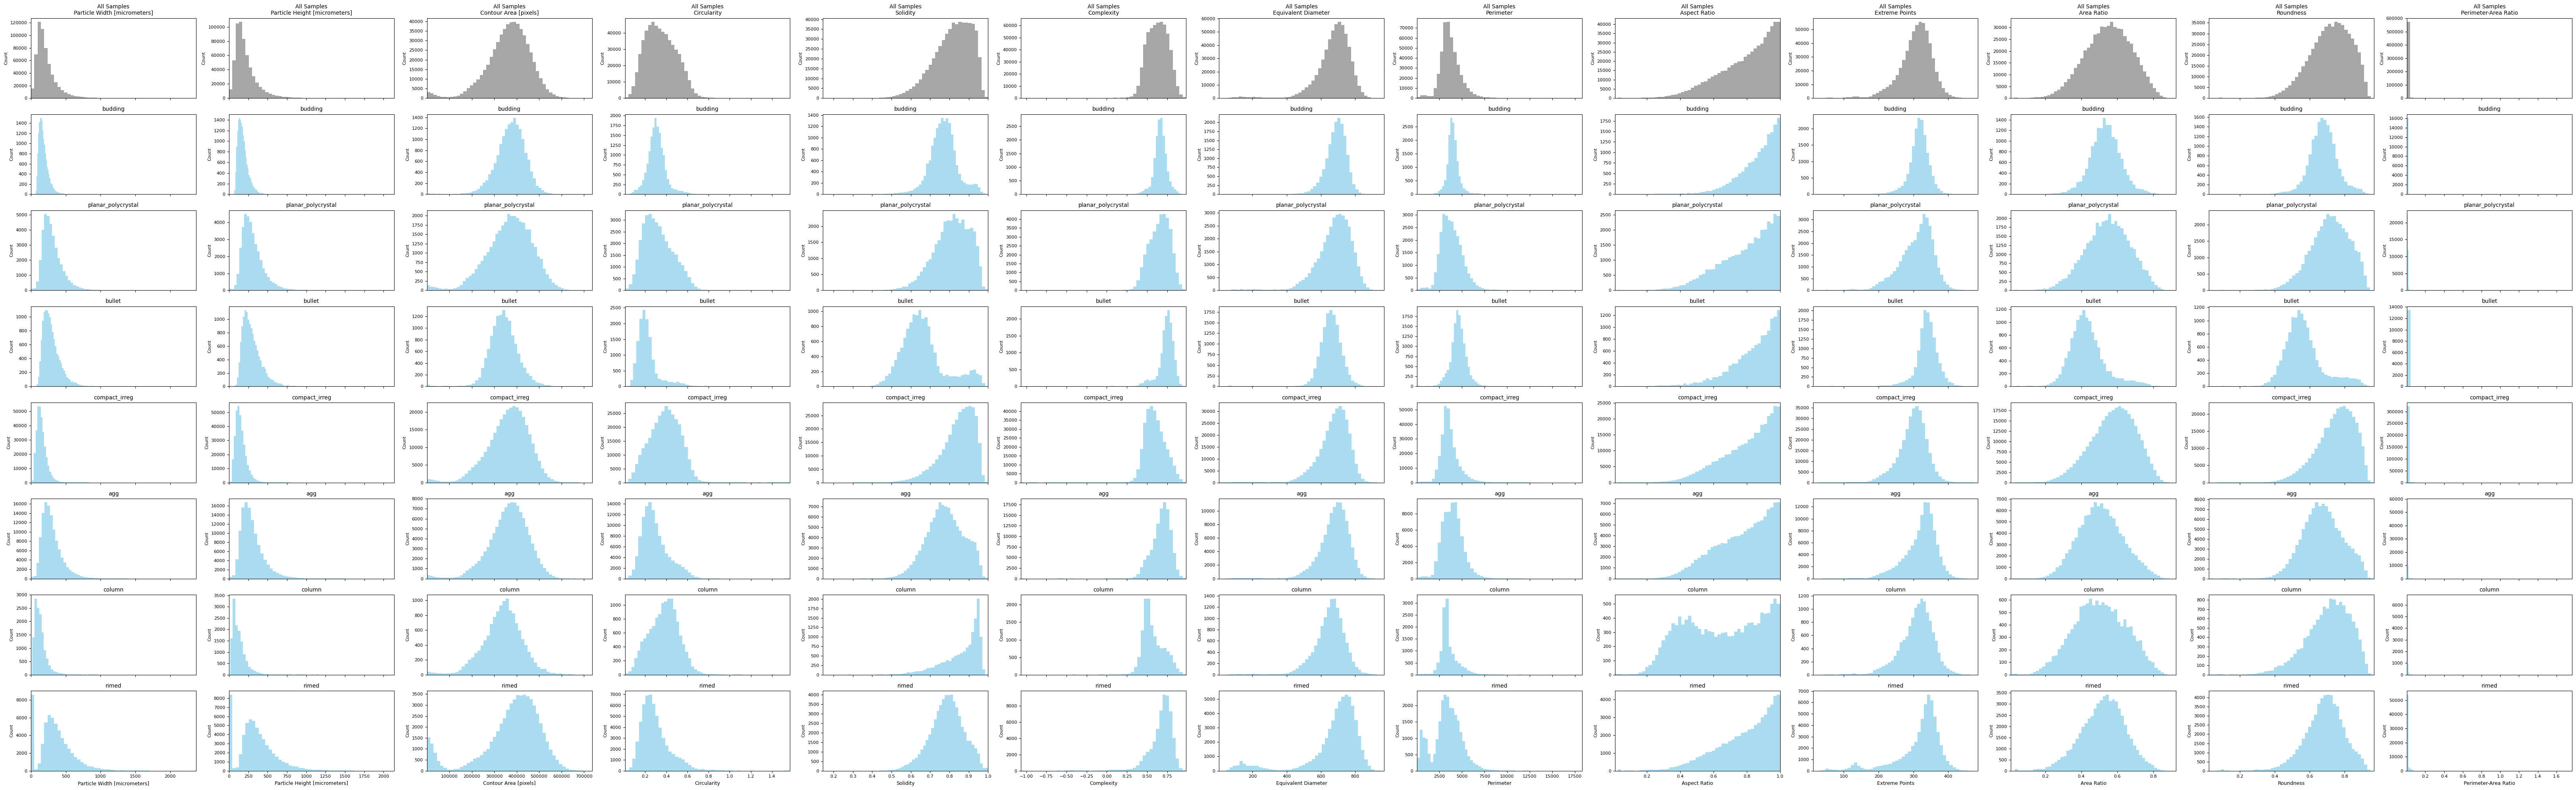

In [57]:
labels = ['budding', 'planar_polycrystal', 'bullet', 'compact_irreg', 'agg', 'column', 'rimed']
features = ['Particle Width [micrometers]', 'Particle Height [micrometers]', 'Contour Area [pixels]', 'Circularity', 'Solidity', 'Complexity', 'Equivalent Diameter', 'Perimeter', 'Aspect Ratio', 'Extreme Points', 'Area Ratio', 'Roundness', 'Perimeter-Area Ratio']

n_rows = len(labels) + 1  # +1 for "All Samples"
n_cols = len(features)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 2.5 * n_rows), sharex='col')
if n_rows == 1 or n_cols == 1:
    axes = axes.reshape((n_rows, n_cols))  # Ensure 2D array

# Compute xlim for each feature based on the total distribution
xlims = []
for j, feature in enumerate(features):
    data = df_no_outliers[feature].dropna()
    xlims.append((data.min(), data.max()))

for j, feature in enumerate(features):
    # First row: All samples
    axes[0, j].hist(df_no_outliers[feature].dropna(), bins=50, color='gray', alpha=0.7)
    axes[0, j].set_title(f'All Samples\n{feature}', fontsize=10)
    axes[0, j].set_xlim(xlims[j])
    axes[0, j].set_ylabel('Count', fontsize=8)
    axes[0, j].tick_params(axis='both', labelsize=8)
    
    # Remaining rows: By classification label
    for i, label in enumerate(labels):
        axes[i+1, j].hist(
            df_no_outliers[df_no_outliers['Classification'] == label][feature].dropna(),
            bins=50, alpha=0.7, color='skyblue', edgecolor='none'
        )
        axes[i+1, j].set_title(label, fontsize=10)
        axes[i+1, j].set_xlim(xlims[j])
        axes[i+1, j].set_ylabel('Count', fontsize=8)
        axes[i+1, j].tick_params(axis='both', labelsize=8)

    # Only set xlabel on the bottom row
    axes[-1, j].set_xlabel(feature, fontsize=9)

plt.tight_layout()
plt.show()

In [6]:
# import embeddings 
emb_path = '../data/combined_campaign_features.pth'
emb = torch.load(emb_path)
df_emb = pd.DataFrame(emb.numpy())

In [7]:
df_emb.shape

(759632, 384)

In [7]:
# merge the two datasets 
df_combined = df_no_outliers.merge(df_emb, left_index=True, right_index=True)
df_combined.head()

,index,filename,date,Frame Width [pixels],Frame Height [pixels],Particle Width [micrometers],Particle Height [micrometers],Cutoff [%],Aggregate [%],Budding [%],...,374,375,376,377,378,379,380,381,382,383
0,271,2000_0309_193624_939_28.png,2000-03-09 19:36:24,106.0,140.0,174.632,248.420,0.00,12.598,78.102,...,6.098347,-2.406156,0.971895,0.052129,-0.519641,5.803663,1.854075,2.262103,-0.017905,1.939258
1,6544,2000_0312_235820_253_18.png,2000-03-12 23:58:20,205.0,228.0,405.842,475.640,0.00,0.030,0.000,...,1.958926,-3.960134,1.251309,-2.670625,5.721043,4.022556,0.077546,8.392792,-2.567546,3.116069
2,14959,2000_0313_195433_318_7.png,2000-03-13 19:54:33,232.0,202.0,411.359,441.451,0.00,0.000,0.000,...,3.094742,-3.879120,2.048366,2.214171,3.990512,8.429094,2.807528,5.612563,-0.643400,6.328050
3,561,2000_0309_200021_189_43.png,2000-03-09 20:00:21,88.0,97.0,137.014,171.312,0.00,0.000,0.002,...,5.998215,-0.531308,-2.083158,-4.157243,2.278965,5.059928,-3.092798,4.273822,2.412360,1.295149
4,18005,2000_0313_203846_761_13.png,2000-03-13 20:38:46,275.0,323.0,546.286,653.653,2.26,2.794,0.231,...,2.104111,-5.691473,2.078868,-4.374487,5.303424,4.254625,4.370141,6.521928,1.132827,6.860025


In [8]:
# Train/Val/Test split 
random_seed=666
# 70% train, 30% temp
df_train, df_temp = train_test_split(df_combined, test_size=0.3, random_state=random_seed)

# Split temp into 15% val, 15% test (each is 0.15 of original)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=random_seed)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 404803, Val: 86744, Test: 86744


In [15]:
# Fit Regression
x_cols = list(range(0, 384))
y_cols = ['Aggregate [%]', 'Budding [%]', 'Bullet Rosette [%]', 'Column [%]', 'Compact Irregular [%]', 'Fragment [%]', 'Planar Polycrystal [%]', 'Rimed [%]', 'Sphere [%]']
x = df_train[x_cols]
y = df_train[y_cols]
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [17]:
df_val[y_cols].head()

,Aggregate [%],Budding [%],Bullet Rosette [%],Column [%],Compact Irregular [%],Fragment [%],Planar Polycrystal [%],Rimed [%],Sphere [%]
659156,0.044,13.707,86.249,0.000,0.000,0.000,0.0,0.000,0.000
277844,98.585,0.000,0.000,0.000,0.000,1.104,0.0,0.311,0.000
125381,3.476,0.000,0.000,0.003,96.422,0.097,0.0,0.000,0.001
144947,0.000,0.000,0.000,0.000,100.000,0.000,0.0,0.000,0.000
709619,0.000,0.000,0.000,0.000,100.000,0.000,0.0,0.000,0.000


In [20]:
# Evaluate on val data
x_val = df_val[x_cols]
y_val = df_val[y_cols]
y_val_pred = model.predict(x_val)

In [21]:
from sklearn.metrics import r2_score

# If y_val and y_val_pred are DataFrames or arrays with multiple columns:
r2 = r2_score(y_val, y_val_pred, multioutput='uniform_average')
print(f"R² score (mean over all targets): {r2:.3f}")

# If you want R² for each column separately:
if hasattr(y_val, 'columns'):
    for i, col in enumerate(y_val.columns):
        r2_col = r2_score(y_val.iloc[:, i], y_val_pred[:, i])
        print(f"R² for {col}: {r2_col:.3f}")

R² score (mean over all targets): 0.446
R² for Aggregate [%]: 0.460
R² for Budding [%]: 0.307
R² for Bullet Rosette [%]: 0.596
R² for Column [%]: 0.502
R² for Compact Irregular [%]: 0.707
R² for Fragment [%]: 0.247
R² for Planar Polycrystal [%]: 0.425
R² for Rimed [%]: 0.575
R² for Sphere [%]: 0.197


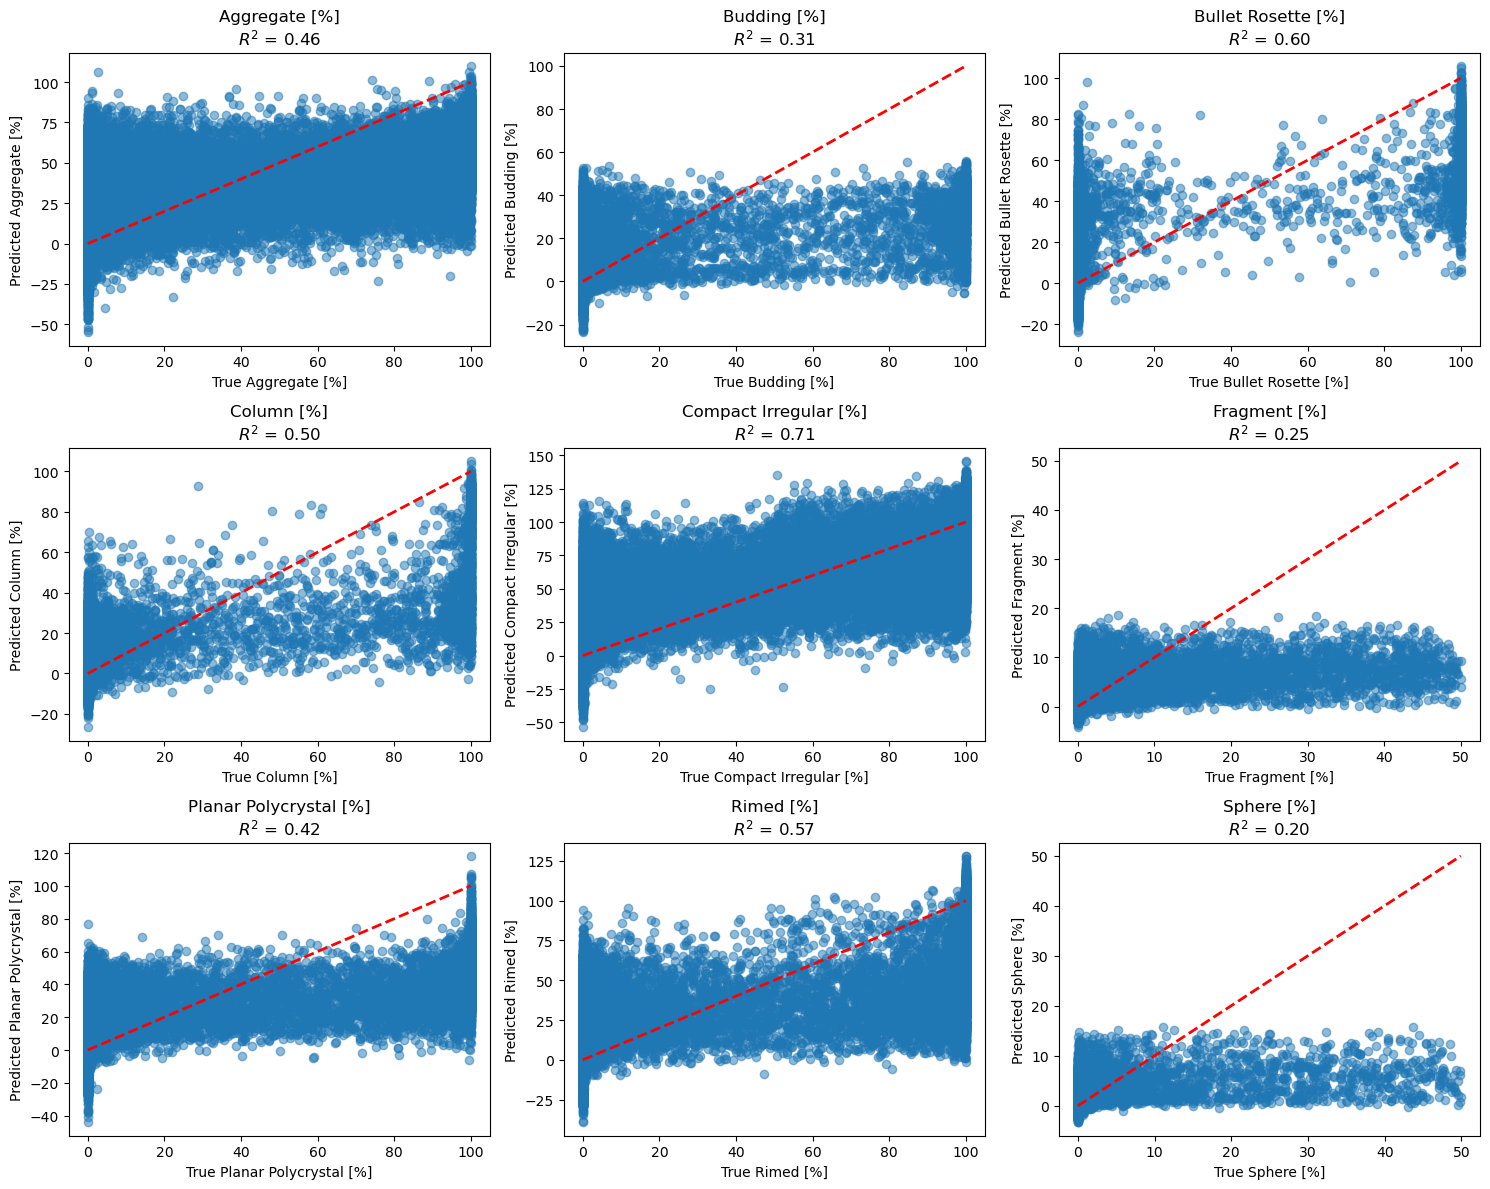

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

n_targets = y_val.shape[1]
n_cols = 3  # Number of columns per row
n_rows = int(np.ceil(n_targets / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(y_val.columns):
    r2_col = r2_score(y_val.iloc[:, i], y_val_pred[:, i])
    axes[i].scatter(y_val.iloc[:, i], y_val_pred[:, i], alpha=0.5)
    axes[i].set_xlabel(f'True {col}')
    axes[i].set_ylabel(f'Predicted {col}')
    axes[i].set_title(f'{col}\n$R^2$ = {r2_col:.2f}')
    axes[i].plot(
        [y_val.iloc[:, i].min(), y_val.iloc[:, i].max()],
        [y_val.iloc[:, i].min(), y_val.iloc[:, i].max()],
        'r--', lw=2
    )  # 1:1 line

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

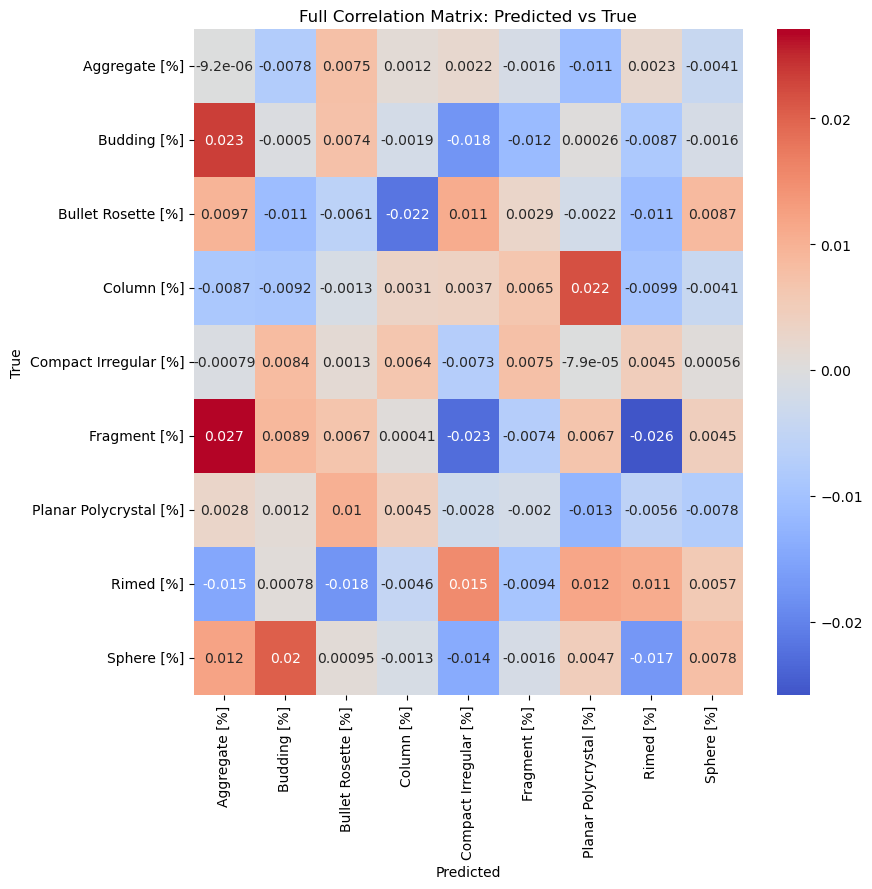

In [24]:
# Ensure y_val_pred and y_val are DataFrames with the same columns
y_val_pred_df = pd.DataFrame(y_val_pred, columns=y_val.columns)
y_val_df = pd.DataFrame(y_val, columns=y_val.columns)

# Concatenate along columns with suffixes to distinguish
combined = pd.concat([y_val_pred_df.add_suffix('_pred'), y_val_df.add_suffix('_true')], axis=1)

# Compute correlation matrix
corr_matrix_full = combined.corr().loc[
    [col + '_pred' for col in y_val.columns],
    [col + '_true' for col in y_val.columns]
]

plt.figure(figsize=(len(y_val.columns), len(y_val.columns)))
sns.heatmap(
    corr_matrix_full,
    annot=True,
    cmap='coolwarm',
    xticklabels=y_val.columns,
    yticklabels=y_val.columns,
    center=0
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Full Correlation Matrix: Predicted vs True')
plt.tight_layout()
plt.show()